# Quantum Support Vector Machines: Two Moons Evaluation

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  %pip -q install "qiskit>=1.2" "qiskit-machine-learning>=0.7" "qiskit-algorithms>=0.3"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from qiskit.circuit.library import ZZFeatureMap
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

if IN_COLAB:
  REPO_DIR = Path("/content/quantum-support-vector-machines")
  REPO_DIR.mkdir(parents=True, exist_ok=True)
  # ensure directory is importable
  sys.path.append(str(REPO_DIR))
else:
  REPO_DIR = Path.cwd()

from svm import ClassicSVM

from qsvm import (
    QuantumSVM,
    FidelityKernel,
    ProjectedKernel
)

from evaluation_helpers import (
    decision_boundary_plot,
    compose_boundary_grid_from_files
)

RNG = 42
np.random.seed(RNG)

# paths for saved plots
EVAL_DIR = REPO_DIR / "evaluations" / "two_moons"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

PLOT_LINEAR = EVAL_DIR / "linear_boundary.png"
PLOT_RBF = EVAL_DIR / "rbf_boundary.png"
PLOT_QSVM = EVAL_DIR / "qsvm_boundary.png"
PLOT_PQ = EVAL_DIR / "projected_qsvm_boundary.png"

Samples: 600 | Features: 2

Feature ranges:
x0: -1.3650706303480242, 2.4244096656946406
x1: -1.031393655926275, 1.5472581063987607



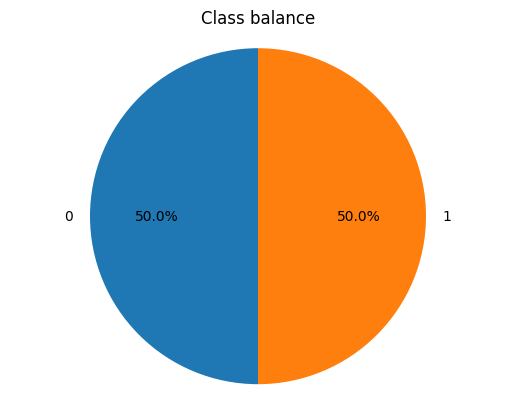

In [3]:
data, labels = make_moons(n_samples=600, noise=0.20, random_state=RNG)

print(f"Samples: {len(data)} | Features: {data.shape[1]}\n")
print("Feature ranges:"),
print(f"x0: {float(data[:,0].min())}, {float(data[:, 0].max())}")
print(f"x1: {float(data[:,1].min())}, {float(data[:, 1].max())}\n")
counts  = Counter(labels)
classes = sorted(counts.keys())
sizes = [counts[c] for c in classes]

plt.figure()
plt.pie(sizes, labels=[str(c) for c in classes], autopct="%1.1f%%", startangle=90)
plt.axis("equal")
plt.title("Class balance")
plt.show()

# train/test split
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.30, stratify=labels, random_state=RNG
)

## Linear SVM

Linear SVM accuracy: 0.861


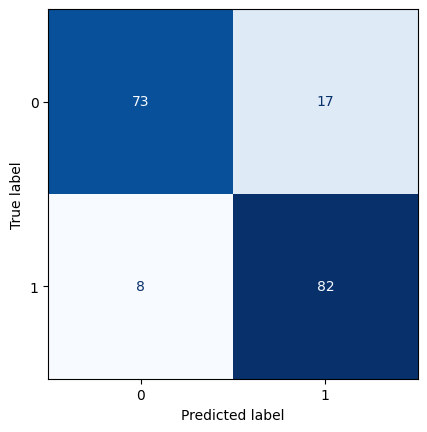

CPU times: user 127 ms, sys: 3.8 ms, total: 131 ms
Wall time: 141 ms


In [4]:
%%time
# train
lin_svm = ClassicSVM(SVC(kernel="linear", C=1.0, random_state=RNG)).fit(x_train, y_train)

# eval
preds_lin_svm = lin_svm.predict(x_test)
acc_lin = accuracy_score(y_test, preds_lin_svm)
print(f"Linear SVM accuracy: {acc_lin:.3f}")

# confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_lin_svm)).plot(cmap = "Blues", colorbar=False)
plt.show()


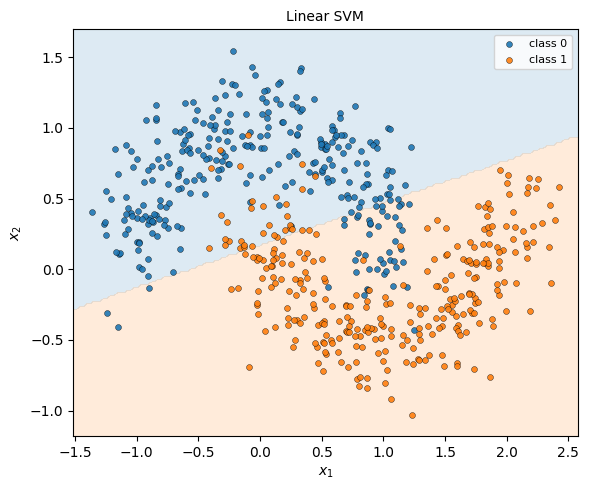

In [5]:
# plot decision boundary
fig_lin = decision_boundary_plot(
    predict_fn=lambda x_batch: lin_svm.predict(x_batch),
    x=data, y=labels, save_path=PLOT_LINEAR,
    title="Linear SVM",
    n=150
)

# Radial Basis Function (RBF) SVM

RBF SVM accuracy: 0.944


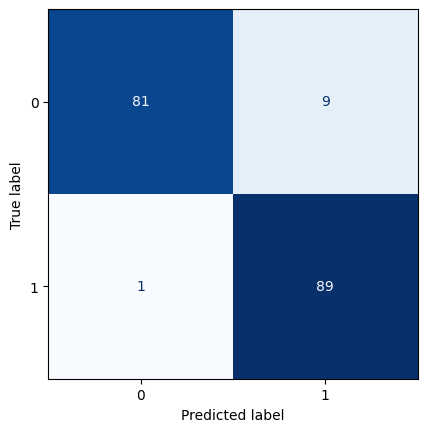

CPU times: user 140 ms, sys: 8.61 ms, total: 149 ms
Wall time: 471 ms


In [6]:
%%time
# train
rbf_svm = ClassicSVM(SVC(kernel="rbf", C=1.0, gamma="scale", random_state=RNG)).fit(x_train, y_train)

# eval
preds_rbf_svm = rbf_svm.predict(x_test)
acc_rbf = accuracy_score(y_test, preds_rbf_svm)
print(f"RBF SVM accuracy: {acc_rbf:.3f}")

# confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_rbf_svm)).plot(cmap = "Blues", colorbar=False)
plt.show()


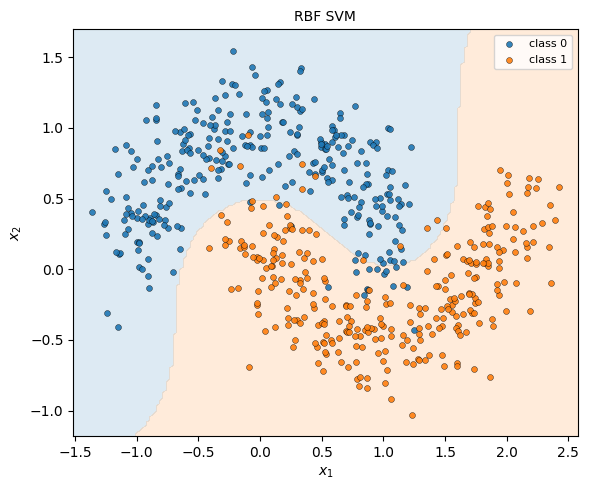

In [7]:
# plot decision boundary
fig_rbf = decision_boundary_plot(
    predict_fn=lambda x_batch: rbf_svm.predict(x_batch),
    x=data, y=labels, save_path=PLOT_RBF,
    title="RBF SVM",
    n=150
)

## Fidelity Quantum Kernel SVM

In [8]:
# build a shallow feature map
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")

# hyperparameter tuning
# note: did not use custom class in order to implement caching with
# the fidelity kernel to speed up grid search
c_grid = [0.5, 1.0, 2.0]

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG)

# scale data
scaler = MinMaxScaler(feature_range=(0.0, np.pi)).fit(x_train)
scaled_x_tr  = scaler.transform(x_train)
# precompute fidelity kernel
fid_kernel = FidelityKernel(feature_map)
kernel = fid_kernel.fit(scaled_x_tr)

best_score, best_cfg = [-1.0, 0.0], None
print("Grid Search Hyperparameter Tuning: Fidelity Kernel QSVM")

for c in c_grid:
    cv_acc = []
    for tr, val in k_fold.split(scaled_x_tr, y_train):
        # slice the precomputed kernel for this fold
        k_tr = kernel[np.ix_(tr, tr)]
        k_val = kernel[np.ix_(val, tr)]

        clf = SVC(kernel="precomputed", C=c, random_state=RNG)
        clf.fit(k_tr, y_train[tr])
        preds = clf.predict(k_val)
        cv_acc.append(accuracy_score(y_train[val], preds))

    mean_acc, std = float(np.mean(cv_acc)), float(np.std(cv_acc, ddof=1))
    print(f"Accuracy: {mean_acc:.3f}{chr(177)}{std:.3f} with C={c}")
    if mean_acc > best_score[0]:
        best_score, best_cfg = [mean_acc, std], {"C": c}

print("\nBest model:\n")
print(f"Accuracy: {best_score[0]:.3f}{chr(177)}{best_score[1]:.3f} with C={best_cfg['C']}")


Grid Search Hyperparameter Tuning: Fidelity Kernel QSVM
Accuracy: 0.717±0.029 with C=0.5
Accuracy: 0.733±0.023 with C=1.0
Accuracy: 0.733±0.042 with C=2.0

Best model:

Accuracy: 0.733±0.023 with C=1.0


Fidelity QSVM accuracy: 0.761


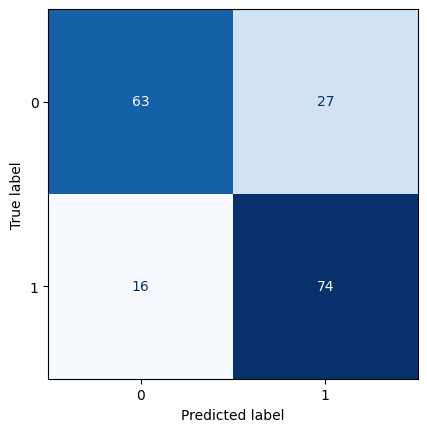

CPU times: user 24min 14s, sys: 2.38 s, total: 24min 17s
Wall time: 24min 39s


In [9]:
%%time
# QSVM uses MinMax scaling internally, set to [0, π] for this feature map
qsvm_fqk = QuantumSVM(kernel=FidelityKernel(feature_map), C=best_cfg["C"], scale_range=(0.0, np.pi), seed=RNG)
qsvm_fqk.fit(x_train, y_train)

# eval
preds_qsvm_fqk = qsvm_fqk.predict(x_test, batch_size=1024)
acc_fqk = accuracy_score(y_test, preds_qsvm_fqk)
print(f"Fidelity QSVM accuracy: {acc_fqk:.3f}")

# confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_qsvm_fqk)).plot(cmap = "Blues", colorbar=False)
plt.show()


CPU times: user 1h 50min 35s, sys: 12.9 s, total: 1h 50min 48s
Wall time: 1h 52min 1s


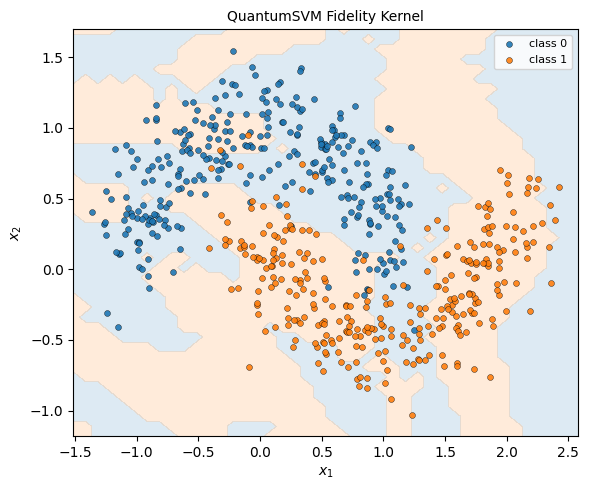

In [10]:
%%time
# plot decision boundary
sv_count_q = len(qsvm_fqk._clf.support_)
fig_qsvm = decision_boundary_plot(
    predict_fn=lambda x_batch: qsvm_fqk.predict(x_batch, batch_size=1024),
    x=data, y=labels, save_path=PLOT_QSVM,
    title="QuantumSVM Fidelity Kernel",
    budget=500000, sv_count=sv_count_q, min_n=35
)

## Projected Quantum Kernel SVM

In [11]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")

# hyperparameter tuning
c_grid = [0.5, 1.0, 2.0]
gamma_grid = [0.5, 1.0, 2.0]

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG)

best_score, best_cfg = [-1.0, 0.0], None
print("Grid Search Hyperparameter Tuning: Projected Kernel QSV")
for c in c_grid:
    for gamma in gamma_grid:
        cv_acc = []
        for tr, val in k_fold.split(x_train, y_train):
            kernel  = ProjectedKernel(feature_map, gamma=gamma)
            clf = QuantumSVM(kernel=kernel, C=c, scale_range=(0.0, np.pi), seed=RNG)
            clf.fit(x_train[tr], y_train[tr])
            preds = clf.predict(x_train[val])
            cv_acc.append(accuracy_score(y_train[val], preds))
        mean_acc, std = float(np.mean(cv_acc)), float(np.std(cv_acc, ddof=1))
        print(f"Accuracy: {mean_acc:.3f}{chr(177)}{std:.3f} with C={c}, gamma={gamma}")
        if mean_acc > best_score[0]:
            best_score, best_cfg = [mean_acc, std], {"C": c, "gamma": gamma}
print("\nBest model:\n")
print(f"Accuracy: {best_score[0]:.3f}{chr(177)}{best_score[1]:.3f} with C={best_cfg['C']}, gamma={best_cfg['gamma']}")

Grid Search Hyperparameter Tuning: Projected Kernel QSV
Accuracy: 0.717±0.058 with C=0.5, gamma=0.5
Accuracy: 0.743±0.043 with C=0.5, gamma=1.0
Accuracy: 0.750±0.033 with C=0.5, gamma=2.0
Accuracy: 0.724±0.035 with C=1.0, gamma=0.5
Accuracy: 0.743±0.040 with C=1.0, gamma=1.0
Accuracy: 0.750±0.026 with C=1.0, gamma=2.0
Accuracy: 0.745±0.039 with C=2.0, gamma=0.5
Accuracy: 0.743±0.040 with C=2.0, gamma=1.0
Accuracy: 0.752±0.029 with C=2.0, gamma=2.0

Best model:

Accuracy: 0.752±0.029 with C=2.0, gamma=2.0


Projected QSVM accuracy: 0.767


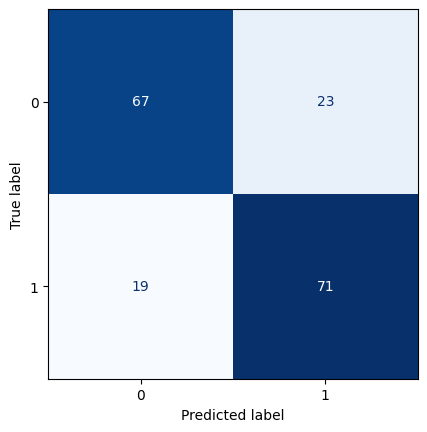

CPU times: user 1.13 s, sys: 2 ms, total: 1.13 s
Wall time: 1.01 s


In [12]:
%%time
proj_kernel = ProjectedKernel(feature_map, gamma=best_cfg["gamma"])
qsvm_pqk = QuantumSVM(kernel=proj_kernel, C=best_cfg["C"], scale_range=(0.0, np.pi), seed=RNG)

# train
qsvm_pqk.fit(x_train, y_train)

# eval
preds_qsvm_pqk = qsvm_pqk.predict(x_test, batch_size=1024)
acc_pqk = accuracy_score(y_test, preds_qsvm_pqk)
print(f"Projected QSVM accuracy: {acc_pqk:.3f}")

# confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_qsvm_pqk)).plot(cmap = "Blues", colorbar=False)
plt.show()


CPU times: user 3.8 s, sys: 9.96 ms, total: 3.81 s
Wall time: 3.98 s


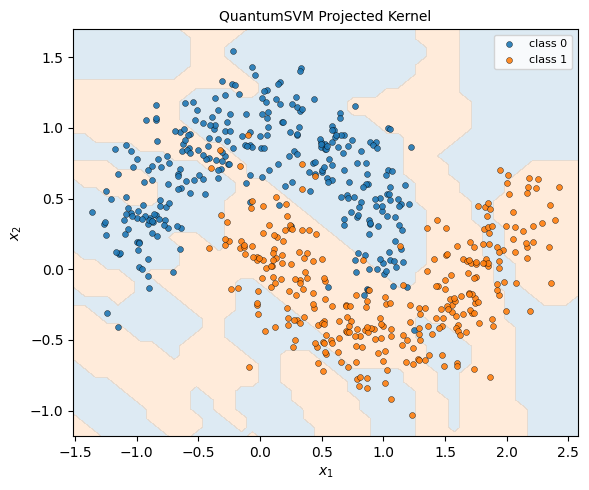

In [13]:
%%time
# plot decision boundary
sv_count_p = len(qsvm_pqk._clf.support_)
fig_proj = decision_boundary_plot(
    predict_fn=lambda x_batch: qsvm_pqk.predict(x_batch, batch_size=1024),
    x=data, y=labels, save_path=PLOT_PQ,
    title="QuantumSVM Projected Kernel",
    budget=500000, sv_count=sv_count_p, min_n=35
)

Final Accuracies:
  Linear SVM: 0.861
  RBF SVM: 0.944
  Fidelity QSVM: 0.761
  Projected QSVM: 0.767


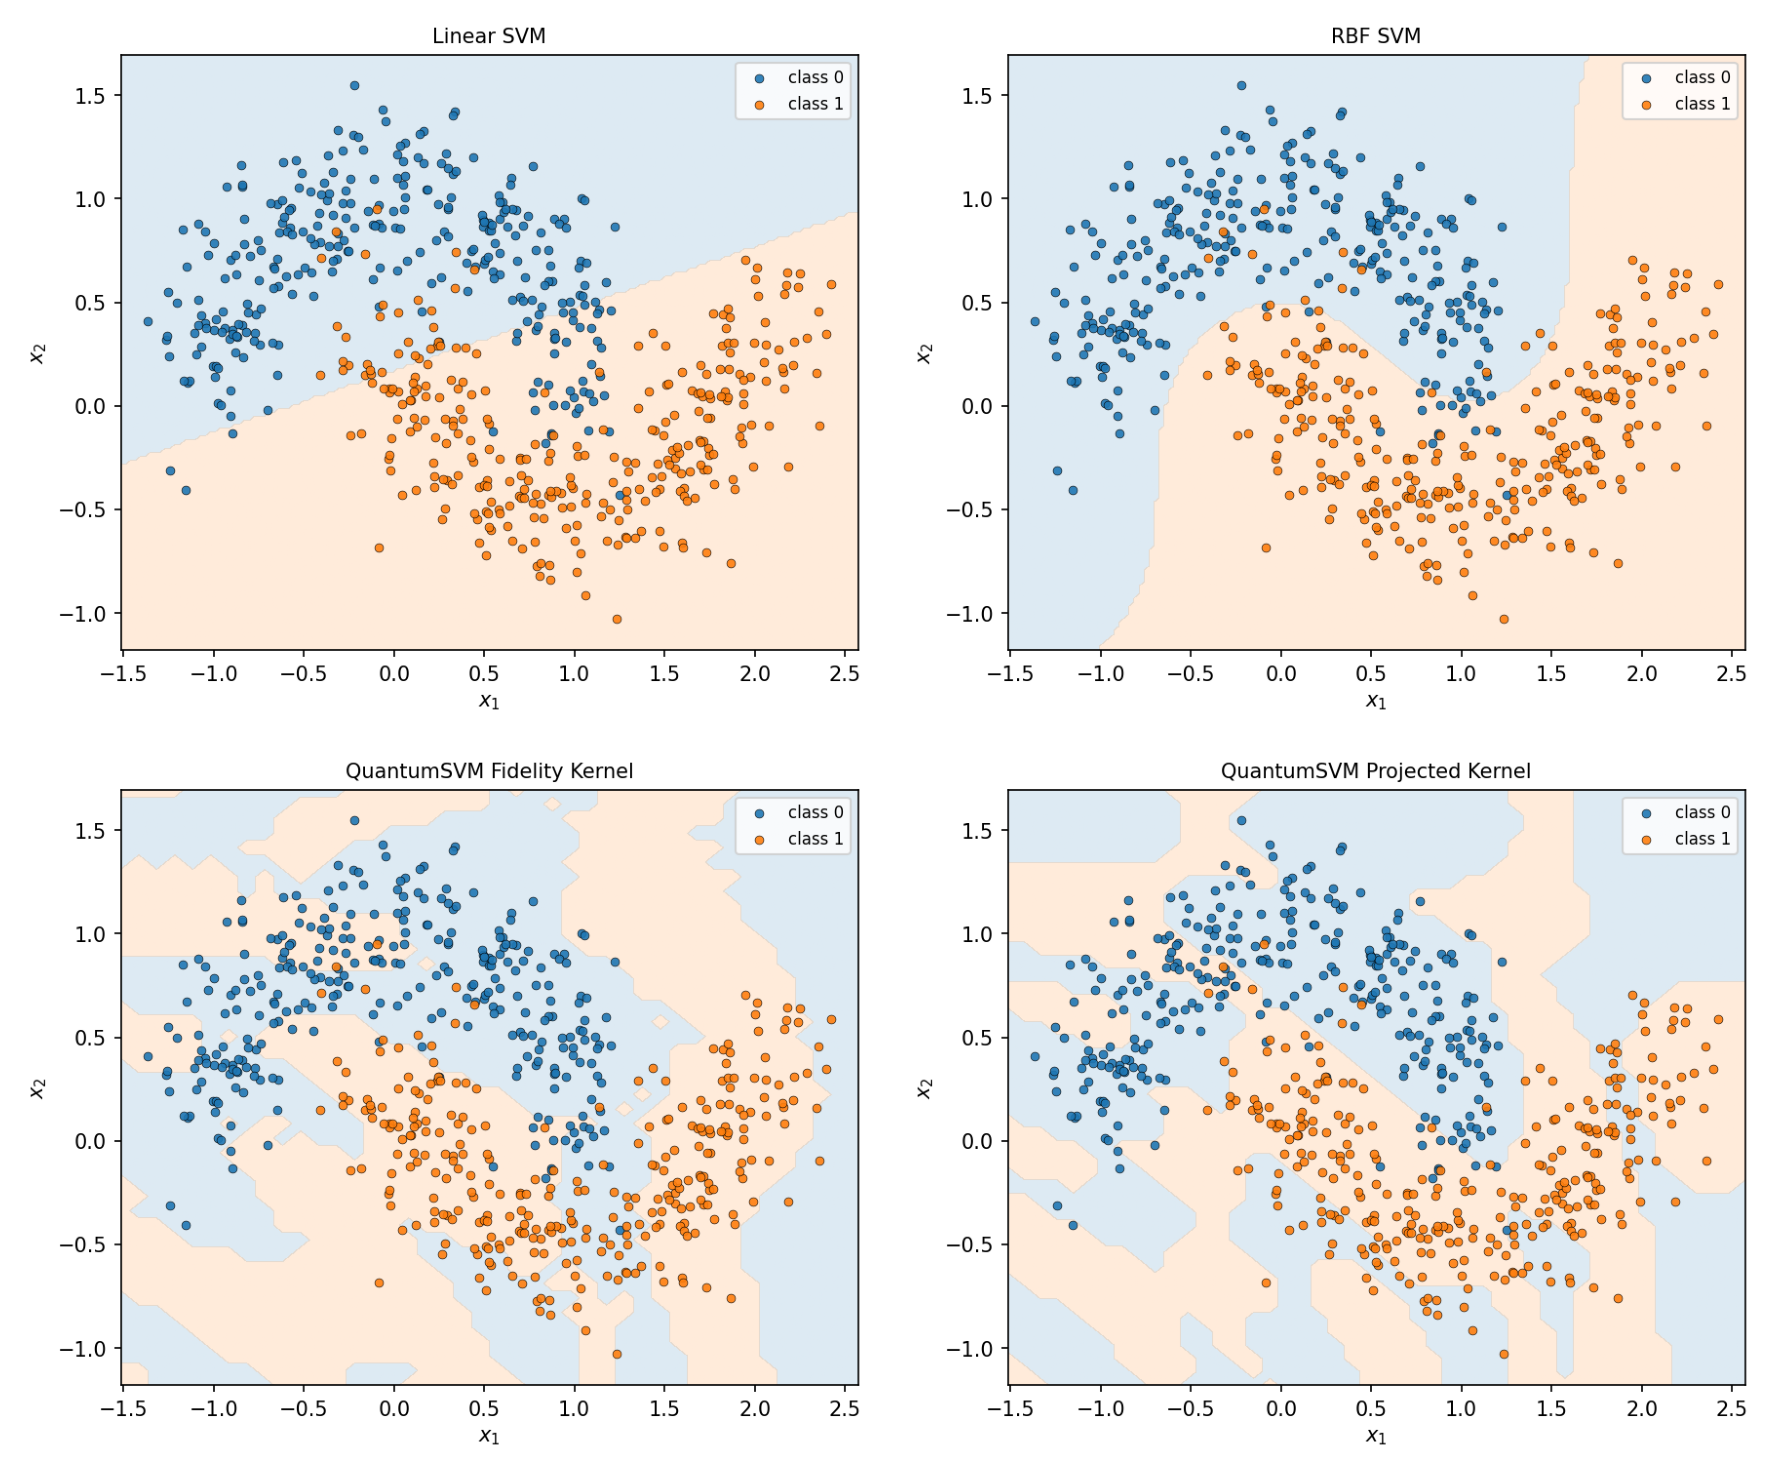

In [14]:
# accuracy summary
acc_table = {
    "Linear SVM": acc_lin,
    "RBF SVM": acc_rbf,
    "Fidelity QSVM": acc_fqk,
    "Projected QSVM": acc_pqk,
}
print("Final Accuracies:")
for k, v in acc_table.items():
    print(f"  {k}: {v:.3f}")


_ = compose_boundary_grid_from_files(
    image_paths=[PLOT_LINEAR, PLOT_RBF, PLOT_QSVM, PLOT_PQ],
    save_path=str(EVAL_DIR / "final_boundaries.png"),
    cols=2
)
plt.show()
